In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data_pixels import *
from amorgibbs import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
##imgs generation parameters
pixels = 64
dpi = 200
radius = 3
imgs_directory = "/home/hao/Research/amortized/AmortizedGibbs/disps/images_test/"
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30 + 2*radius
noise_ratio = 1.0

## Model Parameters
num_particles_rws = 10
mcmc_steps = 50
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = int(1000 / mcmc_steps) 
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "stepwise_enc-%drws-%dmcmc-%dsmc-enc-%s" % (num_particles_rws, mcmc_steps, num_particles_smc, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))



## VAE Parameters
NUM_HIDDEN_PIXELS = 128
NUM_LATENTS_PIXELS = 2
NUM_PIXELS = pixels * pixels

In [3]:
# T = 50
# noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
# init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
# v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
# init_v = init_v / v_norm * dt ## to make the velocity lying on a circle

# STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

# plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
T = 50
init_v = init_velocity(dt)
alpha_trans_0 = initial_trans_prior(K)
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio
STATE, mu_ks, cov_ks, Pi, Y_true, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov, radius)
generate_frames(STATE, Boundary, pixels, dpi, radius, 0)   

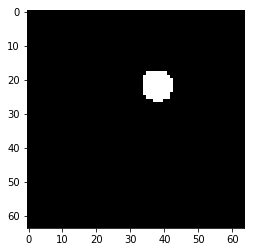

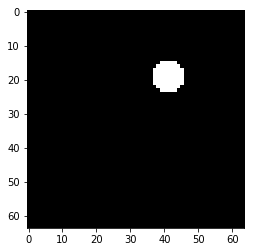

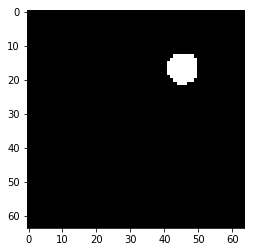

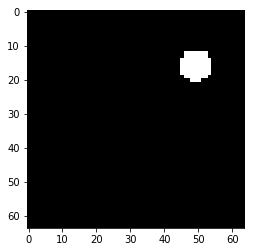

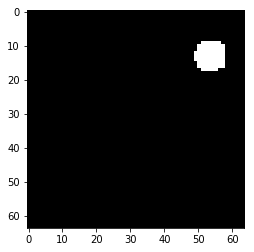

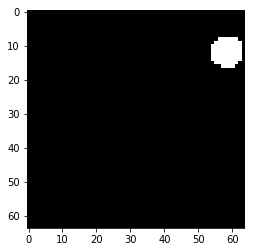

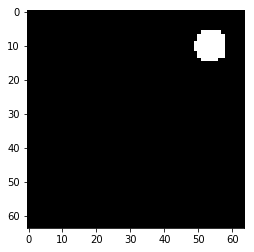

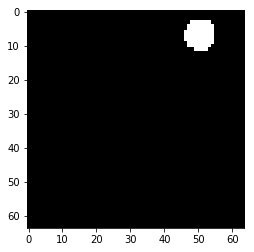

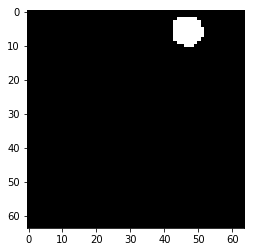

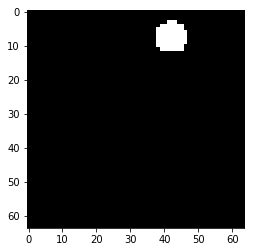

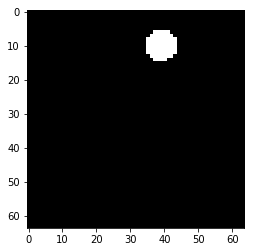

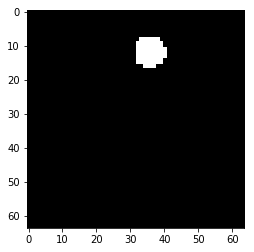

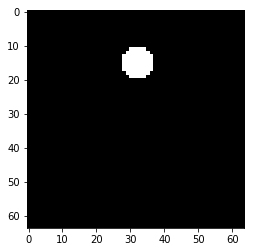

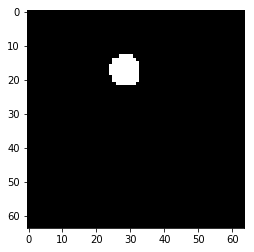

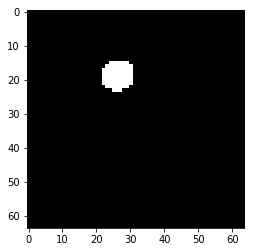

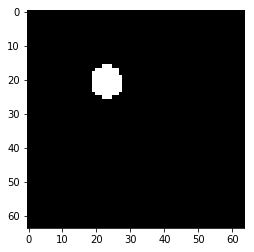

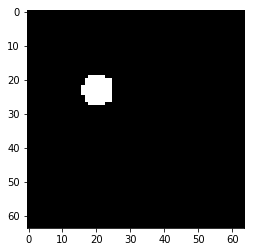

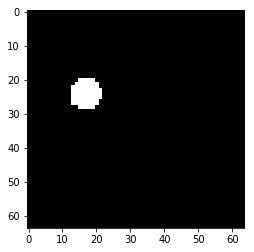

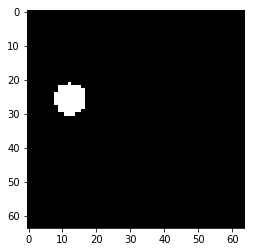

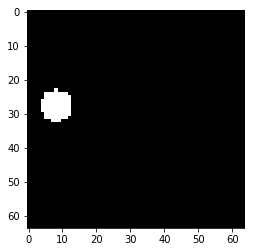

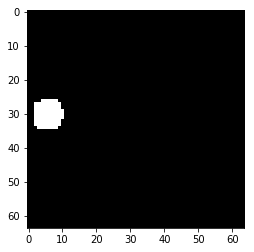

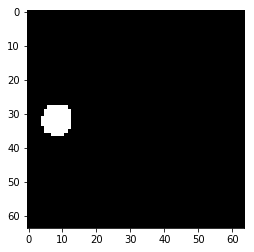

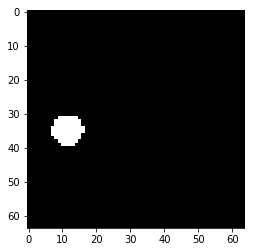

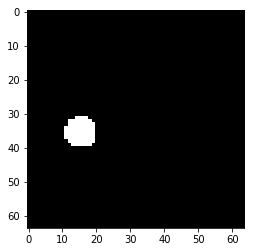

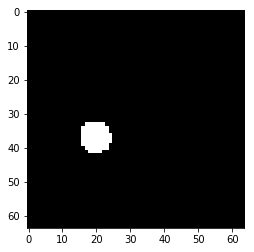

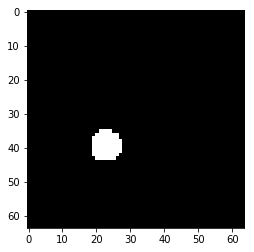

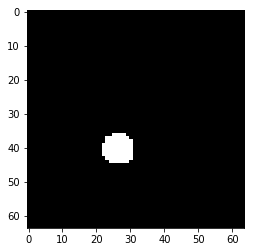

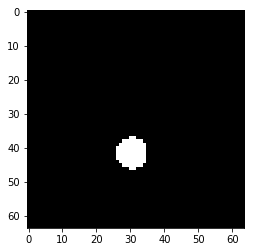

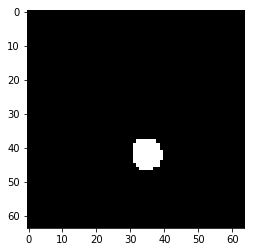

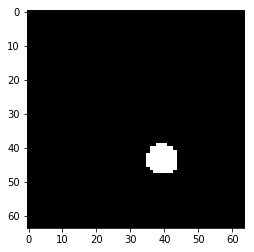

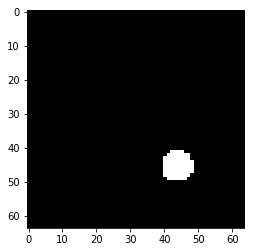

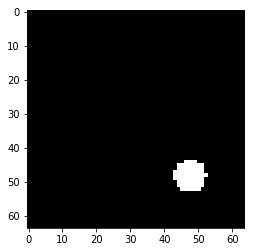

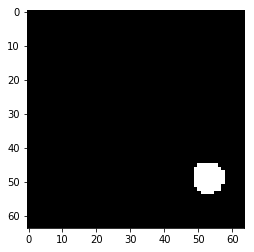

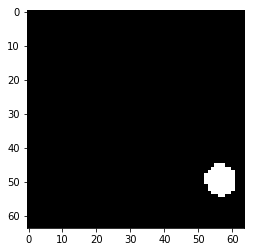

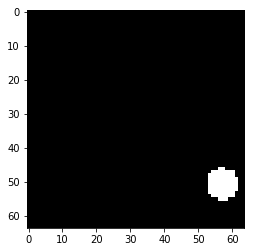

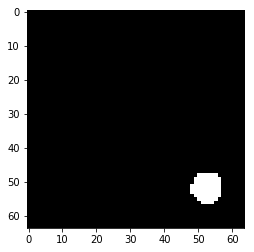

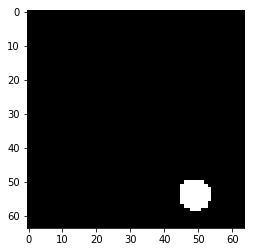

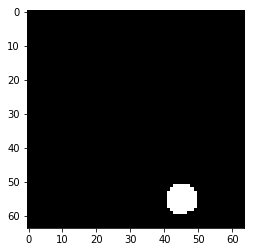

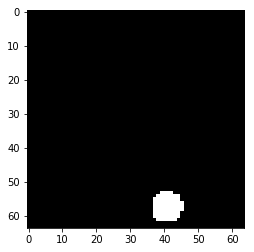

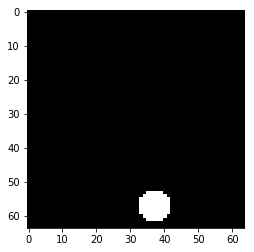

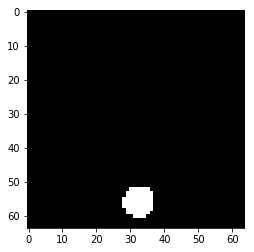

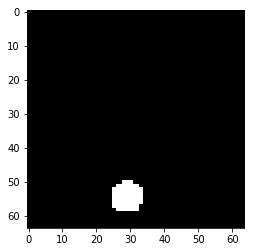

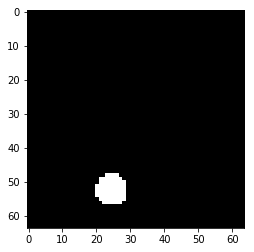

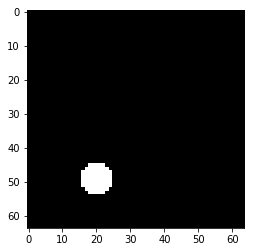

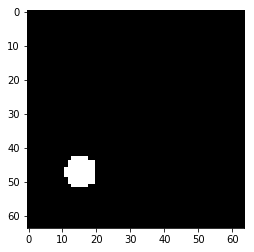

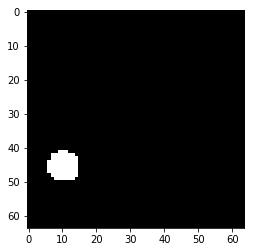

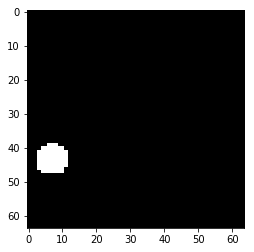

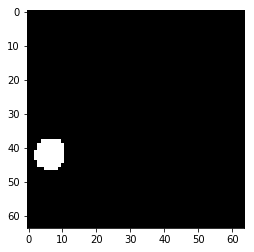

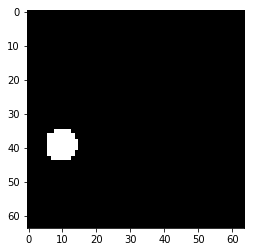

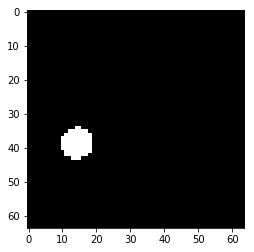

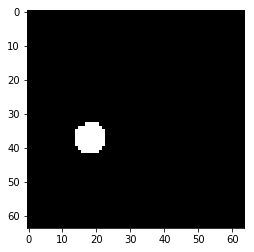

In [5]:
T = 50
seq_imgs = load_pixels(imgs_directory, T, pixels, 0)

In [7]:
a = seq_imgs[0].view(-1, pixels*pixels)
b = seq_imgs[1].view(-1, pixels*pixels)
BCE(a, b)

tensor([1595.6915])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [ ]:
## VAE
class Encoder_Pixels(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN_PIXELS,
                       num_latent=NUM_LATENTS_PIXELS):
        super(self.__class__, self).__init__()

        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU(),
                            nn.Linear(num_hidden, num_hidden),
                            nn.ReLU())
        
        self.y_mean = nn.Linear(num_hidden, num_latent)
        self.y_log_std = nn.Linear(num_hidden, num_latent)

    def forward(self, images):
        hiddens = self.enc_hidden(images)
        y_mean = self.y_mean(hiddens)
        y_log_std = self.y_log_std(hiddens).exp()
        return q
    
def BCE(x_mean, x, EPS=1e-9):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

In [ ]:
def initialize():
    enc_pixels = Encoder_Pixels()
    enc = Encoder()

    optimizer =  torch.optim.Adam(list(enc.parameters()) + list(enc_pixels.parameters()),lr=LEARNING_RATE)    
    return enc_pixels, enc, optimizer
enc_pixels, enc, optimizer = initialize()

In [ ]:
EUBOs, ELBOs, KLs, ESSs, enc = stepwise_optimal(enc, D, K, NUM_EPOCHS, num_particles_rws, num_particles_smc, mcmc_steps)

In [ ]:
save_params(KLs, EUBOs, ELBOs, ESSs, PATH_ENC)

In [ ]:
plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)

In [ ]:
# plot_dirs(variational, alpha_trans_0, Zs_true, T, K, vmax=15)